In [5]:
# Khai báo các thư viện cần thiết
import gym
import numpy as np
from gym.spaces import Discrete
import random
from collections import deque
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from collections import Counter

In [6]:
# Khai báo các hằng số sử dụng
class Action:
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
class Maze:
    WALL = -1
    PATH = 0
    UNEXPLORED = 1
    GOAL = 2
    AGENT_POSITION = 3
class Buff:
    NONE = 0
    SENRIGAN = 1
    TOU_NO_HIKARI = 2
    SLIME_SAN_ONEGAI = 3
    UNMEI_NO_MICHI = 4
class Debuff:
    NONE = 0
    WAAMU_HOURU = 1
    SHIN_NO_MEIRO = 2

In [7]:
# Khai báo tên model
while True:
    model_name = input("Enter model name: ")
    if model_name == "":
        print("Model name cannot be empty. Please enter a valid name.")
    else:
        os.makedirs(model_name, exist_ok=True)
        break

In [ ]:
# Môi trường Mê cung

class MazeEnv(gym.Env):
    # Môi trường mê cung
    # Maze: Mê cung được tạo ra ngẫu nhiên với các ô đường và tường
    # Với các ô đường được đánh dấu là 0 và các ô tường được đánh dấu là -1, ô đích được đánh dấu là 2
    # Discovered_maze: Mê cung đã được khám phá trong quá trình di chuyển của tác tử
    # Với các ô đường được đánh dấu là 0, các ô tường được đánh dấu là -5, đích được đánh dấu là 10, ô chưa được khám phá được đánh dấu là 1
    # Giá trị các ô đường giảm dần mỗi lần tác tử đi qua
    # Agent_position: Vị trí hiện tại của tác tử trong mê cung
    # Base_position: Vị trí ban đầu của tác tử trong mê cung
    # Goal_position: Vị trí đích trong mê cung
    # Buff: Biến để xác định xem tác tử có đang sử dụng buff senrigan hay không
    # Debuff: Biến để xác định xem tác tử có đang bị debuff shin no meiro hay không

    def __init__(self, maze_size, local_obs_size = 3, max_steps = 15, path_percent = 70):
        """
        Khởi tạo môi trường Mê cung.

        Args:
        - maze_size (int): Kích thước của mê cung (ví dụ: 50x50).
        - max_steps (int): Số bước tối đa cho mỗi tập.
        - path_percent (int): Tỷ lệ phần trăm ô đường trong mê cung (0-100).
        """
        # Đặt các thông số của môi trường
        super(MazeEnv, self).__init__()  # Kế thừa từ gym.Env
        
        self.maze_size = maze_size
        self.max_steps = max_steps
        self.path_percent = path_percent
        self.local_obs_size = local_obs_size
        
        self.maze = np.ones((maze_size, maze_size), dtype=int)  # Mặc định là chưa biết (1)
        self.goal_position = (maze_size * 5 // 6, maze_size * 5 // 6)  # Đích cố định tại giữa khu vực đích
        self.senrigan_buff = False
        self.shin_no_meiro_debuff = False

        # Định nghĩa action_space (0: lên, 1: xuống, 2: trái, 3: phải)
        self.action_space = Discrete(4)

    # Các phương thức liên quan đến tái tạo mê cung
    def reset(self, buff = Buff.NONE, debuff = Debuff.NONE):
        self.base_position = (self.maze_size // 6 - 1, self.maze_size // 6 - 1)
        self.agent_position = self.base_position
        return self.regenerate_maze(buff, debuff)
    
    def regenerate_maze(self, buff = Buff.NONE, debuff = Debuff.NONE):
        # Kích hoạt buff
        if buff == Buff.SENRIGAN:
            self.senrigan_buff = True
        else:
            self.senrigan_buff = False
        if buff == Buff.UNMEI_NO_MICHI:
            adder = 1
        else:
            adder = 0
        # Kích hoạt debuff
        if debuff == Debuff.WAAMU_HOURU:
            self.agent_position = (random.randint(self.maze_size // 3, self.maze_size), random.randint(self.maze_size // 3, self.maze_size))
        if debuff == Debuff.SHIN_NO_MEIRO:
            self.shin_no_meiro_debuff = True
        else:
            self.shin_no_meiro_debuff = False
        # Tạo mê cung mới
        self.generate_maze(adder)
        self.create_discovered_maze()

        # Kích hoạt buff
        if buff == Buff.SLIME_SAN_ONEGAI:
            self.bfs(self.agent_position, 50)
        if buff == Buff.TOU_NO_HIKARI:
            local_obs_size = 10
        else:
            local_obs_size = 3
        self.discover_maze(local_obs_size)
        return (self.get_observation(), self.discovered_maze, self.agent_position)

    def generate_maze(self, adder = 0):
        if self.agent_position[0] >= self.maze_size * 2 // 3 and self.agent_position[1] >= self.maze_size * 2 // 3:
            number_of_path = 1 + adder
        else:
            number_of_path = 2 + adder

        total_cells = self.maze_size * self.maze_size
        num_paths = int(total_cells * self.path_percent / 100)
        num_walls = total_cells - num_paths
        maze_values = [Maze.PATH] * num_paths + [Maze.WALL] * num_walls

        while True:  # Sử dụng vòng lặp để tạo lại mê cung nếu không hợp lệ
            random.shuffle(maze_values)  # Xáo trộn các giá trị
    
            # Điền vào mê cung
            self.maze = np.array(maze_values).reshape(self.maze_size, self.maze_size)
    
            # Đặt điểm bắt đầu và đích
            self.maze[self.agent_position] = Maze.PATH # Đặt vị trí tác tử là đường 
            self.maze[self.goal_position] = Maze.GOAL # Đặt vị trí đích
    
            # Kiểm tra tính hợp lệ
            if self.validate_maze(number_of_path):
                break  # Nếu mê cung hợp lệ, thoát vòng lặp

    def validate_maze(self, number_of_path = 0):
        stack = [self.agent_position]
        visited = set()
        d = 0
        
        while stack:
            x, y = stack.pop()
            if self.shin_no_meiro_debuff:
                if (x, y) == self.goal_position:
                    return False
            
            if (x, y) == self.goal_position:
                d += 1
                if d == number_of_path:
                    return True
                continue
            
            if (x, y) in visited:
                continue
            visited.add((x, y))

            # Thêm các ô lân cận vào stack
            neighbors = self.get_neighbors(x, y)
            for nx, ny in neighbors:
                if self.maze[nx, ny] != Maze.WALL and (nx, ny) not in visited:  # Chỉ đi qua đường
                    stack.append((nx, ny))
                    
        return self.shin_no_meiro_debuff  # Không có đường tới đích

    def get_neighbors(self, x, y):
        """
        Lấy danh sách các ô lân cận.
        """
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze_size and 0 <= ny < self.maze_size:
                neighbors.append((nx, ny))
        return neighbors
    
    # Các phương thức liên quan đến mê cung được khám phá
    def create_discovered_maze(self):
        self.discovered_maze = np.zeros((self.maze_size + 10, self.maze_size + 10), dtype=int)  # Tạo mê cung đã khám phá
        self.discovered_maze.fill(Maze.UNEXPLORED)  # Đánh dấu tất cả ô là chưa khám phá (1)
        self.discovered_maze[0 : 5, :] = 5 * Maze.WALL
        self.discovered_maze[:, 0 : 5] = 5 * Maze.WALL
        self.discovered_maze[self.maze_size + 5 : self.maze_size + 10, :] = 5 * Maze.WALL
        self.discovered_maze[:, self.maze_size + 5 : self.maze_size + 10] = 5 * Maze.WALL
        self.discovered_maze[self.goal_position[0] + 5, self.goal_position[1] + 5] = 10  # Đích được đánh dấu là 10

    def discover_maze(self, local_obs_size = 3):
        x, y = self.agent_position
        if self.senrigan_buff:
            half_size = max(5, local_obs_size)  
        else:
            half_size = max(3, local_obs_size)  

        # Xác định giới hạn của vùng quan sát trong mê cung
        min_x = max(0, x - half_size)
        max_x = min(self.maze_size, x + half_size + 1)
        min_y = max(0, y - half_size)
        max_y = min(self.maze_size, y + half_size + 1)

        # Điền dữ liệu từ mê cung vào vùng khám phá
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    self.discovered_maze[x + 5, y + 5] = self.maze[x, y] * 5
        
    # Phương thức chính để thực hiện hành động trong môi trường
    def step(self, action, take_action = True):
        """
        Thực hiện hành động và cập nhật trạng thái của môi trường.
    
        Args:
        - action (int): Hành động 
    
        Returns:
        - local_obs (np.array): Quan sát hiện tại của tác tử
        - global_obs (np.array): Mê cung đã khám phá
        - reward (float): Phần thưởng
        - done (bool): Trạng thái kết thúc
        """
        # Lưu lại trạng thái nếu không thực hiện hành động
        if not take_action:
            saved_position = self.agent_position
            saved_discovered_maze = self.discovered_maze.copy()

        # Lấy vị trí hiện tại của tác tử
        x, y = self.agent_position
    
        # Xác định vị trí mới dựa trên hành động
        if action == Action.UP:  # Lên
            new_x, new_y = x - 1, y
        elif action == Action.DOWN:  # Xuống
            new_x, new_y = x + 1, y
        elif action == Action.LEFT:  # Trái
            new_x, new_y = x, y - 1
        elif action == Action.RIGHT:  # Phải
            new_x, new_y = x, y + 1
    
        # Khởi tạo biến phần thưởng
        reward = 0
        done = False
        
        # Cập nhật vị trí tác tử
        if self.valid_check((new_x, new_y)) and self.discovered_maze[new_x + 5, new_y + 5] != 5 * Maze.WALL:  # Nếu vị trí mới hợp lệ và không phải là tường
            # Nếu vị trí mới hợp lệ, cập nhật vị trí tác tử
            self.agent_position = (new_x, new_y)
            self.discover_maze()

        if self.discovered_maze[new_x + 5, new_y + 5] == 5 * Maze.WALL:
            reward -= 2 * self.maze_size  # Phạt lớn khi va chạm với tường
        elif self.agent_position == self.goal_position:
            reward += 3 * self.maze_size  # Thưởng lớn khi đến đích
            done = True
        else:
            # Tính khoảng cách Manhattan từ vị trí hiện tại tới đích
            current_distance = abs(self.agent_position[0] - self.goal_position[0]) + abs(self.agent_position[1] - self.goal_position[1])
            
            # Tính khoảng cách trước đó
            previous_distance = abs(x - self.goal_position[0]) + abs(y - self.goal_position[1])

            # Tính khoảng cách đã đi được
            moved_distance = 1 + abs(new_x - self.agent_position[0]) + abs(new_y - self.agent_position[1])

            # Tăng thưởng nếu đến gần đích hơn
            if self.discovered_maze[new_x + 5, new_y + 5] == Maze.PATH:  # Nếu ô chưa được khám phá
                if current_distance < previous_distance:
                    reward += 2 * self.maze_size // current_distance  # Thưởng khi di chuyển đến gần đích hơn
                else:
                    reward -= 2 * self.maze_size // moved_distance # Phạt nếu tác tử đi xa hơn
            else:
                # Phạt khi đi vào ô đã khám phá
                reward += self.discovered_maze[new_x + 5, new_y + 5] * self.maze_size // current_distance + self.discovered_maze[new_x + 5, new_y + 5] * self.maze_size // moved_distance
            
            # Giảm giá trị ô đã khám phá
            self.discovered_maze[new_x + 5, new_y + 5] -= 1
        
        # Tạo quan sát hiện tại
        local_obs = self.get_observation()

        #Tạo quan sát toàn mê cung
        return_discovered_maze = self.discovered_maze.copy()
        return_agent_position = self.agent_position
        # Trả lại các giá trị đã lưu nếu không thực hiện hành động
        if not take_action:
            self.agent_position = saved_position
            self.discovered_maze = saved_discovered_maze.copy()
        return local_obs, return_discovered_maze, return_agent_position, reward, done

    # Xuất dữ liệu mê cung
    def render(self):
        render_maze = np.zeros((self.maze_size, self.maze_size), dtype = int) 
        for i in range(self.maze_size):
            for j in range(self.maze_size):
                if self.maze[i][j] == Maze.WALL:
                    render_maze[i][j] = 1
                    continue
                if self.maze[i][j] == Maze.GOAL:
                    render_maze[i][j] = 10
                    continue
                if self.discovered_maze[i + 5, j + 5] < Maze.PATH:
                    render_maze[i][j] = 2
        print(render_maze)
    
    # Phương thức để lấy quan sát hiện tại của tác tử
    def get_observation(self):
        x, y = self.agent_position
        observation = np.zeros((2 * self.local_obs_size + 1, 2*self.local_obs_size + 1), dtype = int)
        observation[:, :] = self.discovered_maze[x + 5 - self.local_obs_size: x + 6 + self.local_obs_size, y + 5 - self.local_obs_size : y + 6 + self.local_obs_size]
        return observation

    def bfs(self, position, step = 50):
        """
        Thuật toán BFS (Breadth-First Search)
    
        Args:
        - position: Đỉnh bắt đầu tìm kiếm.
        - step: số bược di chuyển
    
        """
        # Tập các đỉnh đã duyệt
        visited = set()
        visited_counter = 0
    
        # Hàng đợi (FIFO) để quản lý các đỉnh
        queue = deque([position])
    
        # Bắt đầu duyệt đồ thị
        while queue:
            # Lấy một đỉnh từ hàng đợi
            current = queue.popleft()
            x,y = current
            
            # Kiểm tra nếu đỉnh chưa được duyệt
            if current not in visited:
                visited.add(current)
                visited_counter += 1
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    self.discovered_maze[5 + x, 5 + y] = 5 * self.maze[x, y]
                    
                # Nếu đã duyệt đủ số bước, dừng lại
                if visited_counter >= step:
                    break
                neighbors = self.get_neighbors(x, y)
                for nx, ny in neighbors:
                    if self.maze[nx, ny] != Maze.WALL and (nx, ny) not in visited:  # Chỉ đi qua đường
                        queue.append((nx, ny))
    # Phương thức để kiểm tra tính hợp lệ của một vị trí
    def valid_check(self, p1):
        if 0 <= p1[0] < self.maze_size and 0 <= p1[1] < self.maze_size and self.maze[p1] != Maze.WALL:
            return True
        return False


In [9]:
# Mạng Nơ ron 

class MazeNetCombined(nn.Module):
    def __init__(self):
        super(MazeNetCombined, self).__init__()
        
        # Quan sát cục bộ
        self.conv1_local = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2_local = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_local = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_local = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Fully Connected cho vị trí hiện tại
        self.fc_position = nn.Linear(2, 32)

        # Tầng Fully Connected cuối cùng
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout trước tầng FC3
        self.fc3 = nn.Linear(128, 4)

    def forward(self, local_obs, global_obs, position):
        # Xử lý local_obs
        x_local = F.relu(self.conv1_local(local_obs))
        x_local = F.relu(self.conv2_local(x_local))
        x_local = F.relu(self.conv3_local(x_local))
        x_local = F.relu(self.conv4_local(x_local))
        x_local = x_local.view(x_local.size(0), -1)
        
        # Xử lý vị trí hiện tại
        x_position = F.relu(self.fc_position(position))

        # Kết hợp tất cả
        x = torch.cat((x_local, x_position), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)  # Dropout trước FC3
        x = self.fc3(x)

        return x


In [10]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, experience):
        """Thêm một trải nghiệm (local_obs, global_obs, position, action, reward, next_local_obs, next_global_obs, next_position, done) vào replay buffer."""
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Loại bỏ trải nghiệm cũ nhất nếu đầy
        self.buffer.append(experience)

    def sample(self, batch_size):
        """Trích xuất batch mẫu từ replay buffer."""
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        # Tách dữ liệu thành các phần riêng biệt
        local_obs, global_obs, position, actions, rewards, next_local_obs, next_global_obs, next_position, dones = zip(*batch)
        return (np.array(local_obs), np.array(global_obs), np.array(position), 
                np.array(actions), np.array(rewards), np.array(next_local_obs), 
                np.array(next_global_obs), np.array(next_position), np.array(dones))

    def __len__(self):
        return len(self.buffer)

    def extend(self, buffer):
        """Mở rộng replay buffer bằng cách thêm một buffer khác."""
        if len(self.buffer) + len(buffer.buffer) > self.capacity:
            self.capacity = len(self.buffer) + len(buffer.buffer)
        self.buffer.extend(buffer.buffer)

In [11]:
# Cập nhật model
def update_model(policy_net, target_net, replay_buffer, optimizer, batch_size, gamma, device):
    """
    Cập nhật mô hình chính (policy network) cho mạng có đầu vào đa dạng (local_obs, global_obs, position).

    Args:
    - policy_net (nn.Module): Mạng chính dự đoán giá trị Q(s, a).
    - target_net (nn.Module): Mạng mục tiêu dùng để tính Q_target.
    - replay_buffer (ReplayBuffer): Bộ nhớ replay chứa các kinh nghiệm (local_obs, global_obs, position, action, reward, next_local_obs, next_global_obs, next_position, done).
    - optimizer (torch.optim.Optimizer): Trình tối ưu hóa (Adam, SGD, ...).
    - batch_size (int): Kích thước batch mẫu từ replay buffer.
    - gamma (float): Hệ số chiết khấu (discount factor).
    - device (torch.device): Thiết bị thực thi (CPU hoặc GPU).

    Returns:
    - loss (float): Giá trị mất mát (loss) sau khi cập nhật.
    """
    # Kiểm tra nếu replay buffer chưa đủ dữ liệu
    if len(replay_buffer) < batch_size:
        return None

    # 1. Lấy mẫu từ replay buffer
    batch = replay_buffer.sample(batch_size)
    (local_obs, global_obs, position, actions, rewards, 
     next_local_obs, next_global_obs, next_position, dones) = batch

    # 2. Chuyển đổi dữ liệu sang Tensor và đưa vào thiết bị (CPU/GPU)
    local_obs = torch.tensor(local_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh cho CNN
    global_obs = torch.tensor(global_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    position = torch.tensor(position, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_local_obs = torch.tensor(next_local_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    next_global_obs = torch.tensor(next_global_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    next_position = torch.tensor(next_position, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # 3. Dự đoán Q(s, a) từ policy_net
    q_values = policy_net(local_obs, global_obs, position)  # Đầu ra: (batch_size, num_actions)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Lấy giá trị Q(s, a) cho hành động đã thực hiện

    # 4. Tính toán Q_target bằng target_net
    with torch.no_grad():
        next_q_values = target_net(next_local_obs, next_global_obs, next_position)  # Dự đoán Q(s', a') từ target_net
        max_next_q_values = next_q_values.max(1)[0]  # Lấy giá trị lớn nhất Q(s', a')
        q_targets = rewards + gamma * max_next_q_values * (1 - dones)  # Hàm Bellman

    # 5. Tính hàm mất mát   
    loss = F.mse_loss(q_values, q_targets)

    # 6. Tối ưu hóa mô hình
    optimizer.zero_grad()  # Xóa gradient cũ
    loss.backward()  # Lan truyền ngược (backpropagation)
    optimizer.step()  # Cập nhật trọng số

    return loss.item()


In [12]:
# Chọn hành động
def select_action(env, policy_net, local_obs, global_obs, position, device):
    """
    Chọn hành động dựa trên chiến lược Boltzmann Exploration.

    Args:
    - policy_net (nn.Module): Mạng chính để dự đoán giá trị Q(s, a).
    - local_obs (np.array): Quan sát cục bộ (ví dụ: 11x11).
    - global_obs (np.array): Quan sát toàn bộ mê cung (ví dụ: 50x50).
    - position (list or np.array): Vị trí hiện tại của tác tử (dx, dy).
    - device (torch.device): Thiết bị thực thi (CPU hoặc GPU).

    Returns:
    - action (int): Hành động được chọn (0, 1, 2, 3).
    """
    p1 = (position[0] - 1, position[1])
    p2 = (position[0] + 1, position[1])
    p3 = (position[0], position[1] - 1)
    p4 = (position[0], position[1] + 1)

    # Loại bỏ các hành động không hợp lệ (nếu cần)
    valid_actions = []
    if env.valid_check(p1): valid_actions.append(Action.UP)  # Lên
    if env.valid_check(p2): valid_actions.append(Action.DOWN)  # Xuống
    if env.valid_check(p3): valid_actions.append(Action.LEFT)  # Trái
    if env.valid_check(p4): valid_actions.append(Action.RIGHT)  # Phải

    # Chuyển đổi các quan sát thành Tensor để đưa vào mạng
    local_obs_tensor = torch.tensor(local_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    global_obs_tensor = torch.tensor(global_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    position_tensor = torch.tensor(position, dtype=torch.float32).unsqueeze(0).to(device)

    # Dự đoán giá trị Q(s, a) cho tất cả các hành động
    q_values = policy_net(local_obs_tensor, global_obs_tensor, position_tensor)

    valid_q_values = q_values.squeeze()[valid_actions]  # Chỉ giữ Q của các hành động hợp lệ
    selected_index = valid_q_values.argmax().item()  # Chọn hành động có giá trị Q lớn nhất
    action = valid_actions[selected_index]
    
    return action

In [13]:
# Đồng bộ với mạng mục tiêu
def sync_target_network(q_network, target_network):
    target_network.load_state_dict(q_network.state_dict())

In [14]:
# Lưu, tải trọng số của mô hình

# Lưu trọng số của mô hình
def save_model(model, path):
    torch.save(model, path)
    print(f"Model saved to: {path}")
# Tải trọng số của mô hình
def load_model(path, device = "cuda"):
    policy_model = torch.load(path, map_location=device, weights_only=False)  # Tải mô hình từ file
    target_model = policy_model
    target_model.eval() # Đặt target_model ở chế độ đánh giá
    print(F"Model loaded from: {path}")
    return policy_model, target_model

In [15]:
# Khởi tạo các siêu tham số

# Thiết bị thực thi (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Hyperparameters
gamma = 0.85  # Hệ số chiết khấu (discount factor)
learning_rate = 1e-3  # Learning rate cho optimizer
weight_decay = 1e-3 # weight decay cho optimizer
batch_size = 64  # Kích thước batch khi lấy mẫu từ replay buffer
target_update_frequency = 100  # Số vòng lặp huấn luyện trước khi đồng bộ target_net với policy_net
max_episodes = 10000  # Số lượng tập (episodes) tối đa
replay_buffer_capacity = 5000  # Dung lượng bộ nhớ replay buffer

# Thông tin về môi trường
maze_size = 30 # Kích thước mê cung (30x30)
max_steps = 15  # Số bước tối đa trong mỗi tập (episode)
path_percent = 70  # Tỷ lệ phần trăm ô đường đi trong mê cung (70% đường đi, 30% tường)
buff = Buff.NONE  # Buff cho tác tử (nếu có)

# Mạng chính và mạng mục tiêu
local_obs_size = 3

load = True and os.path.exists(model_name + "/model.pth")
# Nếu có trọng số đã lưu, tải chúng vào mô hình
if load:
    policy_net, target_net = load_model(model_name + "/model.pth", device)
else:
    # Khởi tạo mạng chính (policy_net) và mạng mục tiêu (target_net)
    policy_net = MazeNetCombined().to(device)
    target_net = MazeNetCombined().to(device)
    target_net.load_state_dict(policy_net.state_dict())  # Đồng bộ hóa trọng số ban đầu
    target_net.eval()  # Đặt target_net ở chế độ đánh giá

replay_buffer = ReplayBuffer(capacity=replay_buffer_capacity)

save_rb = ReplayBuffer(capacity=10000)  # Lưu replay buffer để huấn luyện sau này
save_rate = 0.15  # Tỷ lệ lưu replay buffer (15%)

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate, weight_decay = weight_decay)

print("Initialization complete!")

# Lưu thông tin các siêu tham số vào file
with open(model_name + "/bot.info", "w") as file:
    file.write("Maze Environment Configuration:\n")
    file.write(f"maze_size: {maze_size}\n")
    file.write(f"max_steps: {max_steps}\n")
    file.write(f"path_percent: {path_percent}\n")
    file.write(f"buff: {buff}\n")
    
    file.write("\nNeural Network Configuration:\n")
    file.write(f"local_obs_size: {local_obs_size}\n")

    file.write("\nTraining Configuration:\n")
    file.write(f"gamma: {gamma}\n")
    file.write(f"learning_rate: {learning_rate}\n")
    file.write(f"weight_decay: {weight_decay}\n")
    file.write(f"batch_size: {batch_size}\n")
    file.write(f"target_update_frequency: {target_update_frequency}\n")
    file.write(f"max_episodes: {max_episodes}\n")
    file.write(f"replay_buffer_capacity: {replay_buffer_capacity}\n")

    file.write("\nReplay Buffer Configuration:\n")
    file.write(f"save_rate: {save_rate}\n")
print("Bot info file created!")

# Tạo model info
model_info = {}
model_info['model_path'] = model_name + "/model.pth"
model_info['buff'] = buff

with open(model_name + "/model_info.pkl", "wb") as file:
    pickle.dump(model_info, file)
print("Model info file created!")

# Tạo training_info
training_info = {}
training_info['gamma'] = gamma
training_info['learning_rate'] = learning_rate
training_info['weight_decay'] = weight_decay

with open(model_name + "/training_info.pkl", "wb") as file:
    pickle.dump(training_info, file)
print("Training info file created!")


Training on: cuda
Initialization complete!
Bot info file created!
Model info file created!
Training info file created!


In [16]:
# Huấn luyện mô hình

#Khởi tạo môi trường 
counter = 0
step_min = 1000
step_max = 0
done_count = 0
done_statistical = []
env = MazeEnv(maze_size=maze_size, local_obs_size=local_obs_size, max_steps=max_steps, path_percent=path_percent)
env.reset()
# Vòng lặp huấn luyện
for episode in range(max_episodes):
    if counter % env.max_steps == 0:
        # Khởi tạo trạng thái môi trường
        local_obs, global_obs, position = env.regenerate_maze(buff)
    counter += 1
    
    # Chọn hành động
    action = select_action(env, policy_net, local_obs, global_obs, position, device)

    # Tạo buffer cho các hành động
    for i in range(4):
        next_local_obs, next_global_obs, next_position, reward, d = env.step(i, (action==i))

        # Lưu trải nghiệm vào replay buffer
        replay_buffer.push((local_obs, global_obs, position, i, reward,
                            next_local_obs, next_global_obs, next_position, d))

        # Lưu trải nghiệm vào replay buffer để huấn luyện sau này
        if np.random.rand() < save_rate:
            save_rb.push((local_obs, global_obs, position, i, reward,
                        next_local_obs, next_global_obs, next_position, d))
        
        # Cập nhật trạng thái
        if i == action:
            local_obs, global_obs, position = next_local_obs, next_global_obs, next_position
            done = d

    # Huấn luyện mô hình nếu buffer đủ dữ liệu
    if len(replay_buffer) >= batch_size:
        update_model(policy_net, target_net, replay_buffer, optimizer, batch_size, gamma, device)

    # reset môi trường nếu đạt được mục tiêu
    if done:
        done_count += 1
        print(f"Done counter: {done_count}")
        print(f"Number of steps: {counter}")
        if counter > step_max:
            step_max = counter
        if counter < step_min: 
            step_min = counter
        done_statistical.append(counter)
        counter = 0
        local_obs, global_obs, position = env.reset(buff)
    # Đồng bộ target_net định kỳ
    if (episode + 1) % target_update_frequency == 0:
        sync_target_network(policy_net, target_net)

print(f"average number of steps: {(max_episodes - counter) // done_count}")
print(f"max: {step_max}")
print(f"min: {step_min}")
save_model(policy_net, model_name + "/model.pth")

Done counter: 1
Number of steps: 147
Done counter: 2
Number of steps: 246
Done counter: 3
Number of steps: 245
Done counter: 4
Number of steps: 107
Done counter: 5
Number of steps: 188
Done counter: 6
Number of steps: 179
Done counter: 7
Number of steps: 164
Done counter: 8
Number of steps: 124
Done counter: 9
Number of steps: 207
Done counter: 10
Number of steps: 202
Done counter: 11
Number of steps: 171
Done counter: 12
Number of steps: 232
Done counter: 13
Number of steps: 178
Done counter: 14
Number of steps: 139
Done counter: 15
Number of steps: 253
Done counter: 16
Number of steps: 170
Done counter: 17
Number of steps: 158
Done counter: 18
Number of steps: 153
Done counter: 19
Number of steps: 148
Done counter: 20
Number of steps: 214
Done counter: 21
Number of steps: 210
Done counter: 22
Number of steps: 92
Done counter: 23
Number of steps: 182
Done counter: 24
Number of steps: 196
Done counter: 25
Number of steps: 144
Done counter: 26
Number of steps: 112
Done counter: 27
Numbe

In [17]:
# Lưu replay buffer
def save_replay_buffer(replay_buffer, filename="replay_buffer.pkl"):
    """
    Lưu replay buffer vào tệp.

    Args:
    - replay_buffer (ReplayBuffer): Replay buffer cần lưu.
    - filename (str): Tên tệp để lưu replay buffer.

    Returns:
    - None
    """
    with open(filename, 'ab') as f:
        pickle.dump(replay_buffer, f)
        print(f"Replay buffer was saved to {filename}")
        print(f"Replay buffer size: {len(replay_buffer)}")
        replay_buffer.buffer = []
        print("Replay buffer was cleared")
save_replay_buffer(save_rb, filename=model_name + "/replay_buffer.pkl")

Replay buffer was saved to model05/replay_buffer.pkl
Replay buffer size: 5903
Replay buffer was cleared


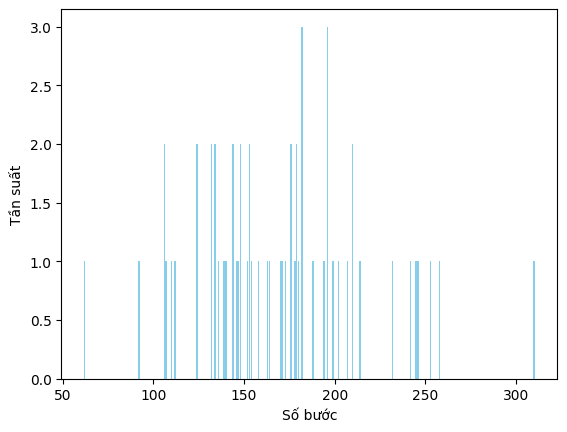

In [18]:
# Hiện biểu đồ thống kê
done_statistical = Counter(done_statistical)
values = list(done_statistical.keys())  # Các giá trị duy nhất
frequencies = list(done_statistical.values())

# Vẽ biểu đồ cột
plt.bar(values, frequencies, color="skyblue")

# Thêm nhãn và tiêu đề
plt.xlabel("Số bước")
plt.ylabel("Tần suất")
plt.title("")

# Hiển thị biểu đồ
plt.show()